<a target="_blank" href="https://colab.research.google.com/github/sonder-art/automl_p24/blob/main/codigo/intro_ml/07_desbalanceo_de_clases.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Clasificacion con desbalanceo de clases

In [89]:
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split



# Generar Datos

In [91]:
def generate_unbalanced_data(n_samples=1000, n_features=5, n_classes=2,
                             class_sep=0.5, weights=[0.9, 0.1], random_state=42):
    """
    Genera datos sintéticos con clases desbalanceadas.

    Parámetros:
    - n_samples: Número total de muestras.
    - n_features: Número de características.
    - n_classes: Número de clases.
    - weights: Lista de pesos para las clases, indicando el desbalance.
    - random_state: Semilla para la generación aleatoria.

    Retorna:
    - X: Matriz de características.
    - y: Vector de etiquetas.
    """
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
                               n_classes=n_classes, 
                               weights=weights,
                               class_sep=class_sep, 
                               n_clusters_per_class=1, random_state=random_state)
    return X, y



In [108]:
# Generar datos desbalanceados
X, y = generate_unbalanced_data(n_samples=1000, n_features=4, 
                                n_classes=2, 
                                weights=[0.9, 0.1], 
                                class_sep=0.01,
                                random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Convertir los conjuntos de datos a DataFrames para un análisis más fácil
train_df = pd.DataFrame(X_train)
train_df.columns = [f'x{c}' for c in train_df.columns]
train_df['Target'] = y_train

test_df = pd.DataFrame(X_test)
test_df.columns = [f'x{c}' for c in test_df.columns]
test_df['Target'] = y_test

train_df.head()

,x0,x1,x2,x3,Target
0,-0.001403,-0.615644,-0.426847,-0.255516,0
1,0.299407,-0.123594,-0.439819,-0.051739,0
2,-0.006215,-0.821366,-0.564349,-0.340892,0
3,0.182340,0.731000,0.293334,0.303126,0
4,-0.117806,-0.584659,-0.267733,-0.242484,0


# EDA

## Balanceo de Datos

In [109]:
# Verificar el balance de clases en los conjuntos de entrenamiento y prueba
train_class_distribution = train_df['Target'].value_counts(normalize=True)
test_class_distribution = test_df['Target'].value_counts(normalize=True)

print("Distribución de clases en el conjunto de entrenamiento:\n", train_class_distribution)
print("\nDistribución de clases en el conjunto de prueba:\n", test_class_distribution)


Distribución de clases en el conjunto de entrenamiento:
 Target
0    0.89
1    0.11
Name: proportion, dtype: float64

Distribución de clases en el conjunto de prueba:
 Target
0    0.9
1    0.1
Name: proportion, dtype: float64


## Estadistica Descriptiva

In [110]:
# Estadísticas descriptivas del conjunto de entrenamiento
train_stats = train_df.describe()
print("\nEstadísticas descriptivas del conjunto de entrenamiento:\n", train_stats)

# Estadísticas descriptivas del conjunto de prueba
test_stats = test_df.describe()
print("\nEstadísticas descriptivas del conjunto de prueba:\n", test_stats)



Estadísticas descriptivas del conjunto de entrenamiento:
                x0          x1          x2          x3      Target
count  800.000000  800.000000  800.000000  800.000000  800.000000
mean     0.000277    0.031719    0.021751    0.013164    0.110000
std      0.453565    1.153651    0.713186    0.478485    0.313085
min     -3.112351   -3.397361   -2.319748   -1.409415    0.000000
25%     -0.125889   -0.766041   -0.494661   -0.317805    0.000000
50%      0.012359   -0.026450    0.000030   -0.010525    0.000000
75%      0.150475    0.792063    0.512957    0.328607    0.000000
max      3.741700    4.005802    2.209366    1.661789    1.000000

Estadísticas descriptivas del conjunto de prueba:
                x0          x1          x2          x3      Target
count  200.000000  200.000000  200.000000  200.000000  200.000000
mean    -0.022418   -0.042997   -0.003437   -0.017813    0.100000
std      0.440129    1.192070    0.709482    0.494417    0.300753
min     -3.554385   -3.462718  

In [111]:
train_df.corr()

,x0,x1,x2,x3,Target
x0,1.000000,0.491891,-0.197675,0.490830,-0.057983
x1,0.491891,1.000000,0.756242,0.999999,-0.012836
x2,-0.197675,0.756242,1.000000,0.757038,0.029122
x3,0.490830,0.999999,0.757038,1.000000,-0.012764
Target,-0.057983,-0.012836,0.029122,-0.012764,1.000000


## Visualizaciones

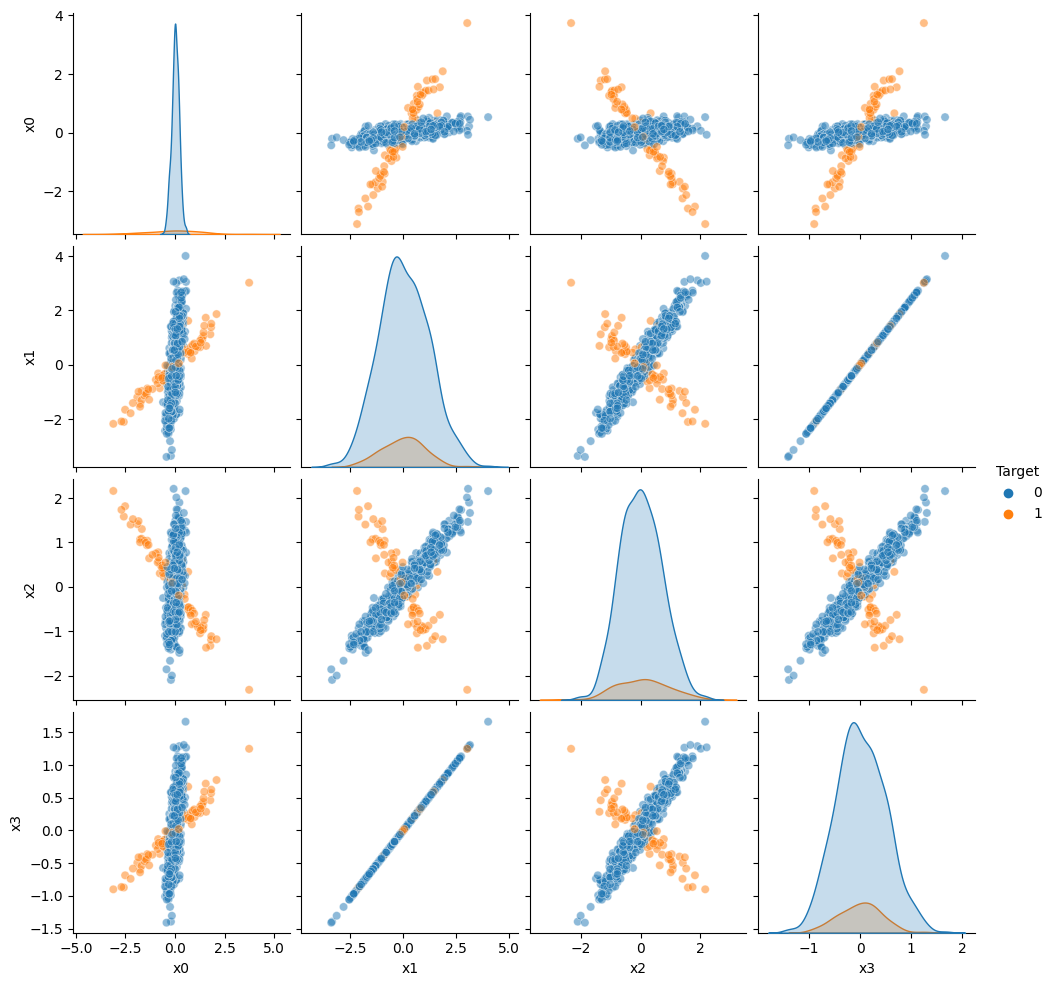

In [112]:
# Gráfico de dispersión para el conjunto de entrenamiento
sns.pairplot(train_df, hue='Target', plot_kws={'alpha': 0.5})
plt.show()

# Entrenamiento

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode
from sklearn.metrics import accuracy_score

In [115]:
def train_logistic_regression(X_train, y_train,**kwargs):
    class_weight = kwargs.get('class_weight',None)
    model = LogisticRegression(class_weight=class_weight)
    model.fit(X_train, y_train)
    return model

def train_decision_tree(X_train, y_train, max_depth=3,**kwargs):
    class_weight = kwargs.get('class_weight',None)
    model = DecisionTreeClassifier(max_depth=max_depth, class_weight=class_weight)
    model.fit(X_train, y_train)
    return model

def train_mode_classifier(X_train, y_train):
    from scipy.stats import mode
    most_common = mode(y_train)[0]
    model = lambda X: np.full(shape=(len(X),), fill_value=most_common)
    return model

In [116]:
def evaluate_model(model, X_test, y_test):
    if callable(model):
        y_pred = model(X_test)
    else:
        y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [117]:
def compare_models(models, X_test, y_test):
    accuracies = [evaluate_model(model, X_test, y_test) for model in models]
    model_names = ['Logistic Regression', 'Decision Tree', 'Mode Classifier']

    plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
    plt.ylabel('Accuracy')
    plt.title('Model Comparison')
    plt.show()


In [118]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, recall_score, matthews_corrcoef

def evaluate_model_on_train_test(model, X_train, y_train, X_test, y_test):
    # Preparar predicciones
    if callable(model):
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

    # Calcular métricas
    metrics = {
        'Accuracy (Train)': accuracy_score(y_train, y_train_pred),
        'Accuracy (Test)': accuracy_score(y_test, y_test_pred),
        'Balanced Accuracy (Train)': balanced_accuracy_score(y_train, y_train_pred),
        'Balanced Accuracy (Test)': balanced_accuracy_score(y_test, y_test_pred),
        'F1 Score (Test)': f1_score(y_test, y_test_pred),
        'F1 Score (Train)': f1_score(y_train, y_train_pred),
        'Recall (Train)': recall_score(y_train, y_train_pred),
        'Recall (Test)': recall_score(y_test, y_test_pred),
        'MCC (Test)': matthews_corrcoef(y_test, y_test_pred),
        'MCC (Train)': matthews_corrcoef(y_train, y_train_pred)
        
    }
    
    # AUC-ROC requiere probabilidades para la clase positiva en caso de clasificadores
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        metrics['AUC-ROC (Test)'] = roc_auc_score(y_test, y_test_proba)
        y_train_proba = model.predict_proba(X_train)[:, 1]
        metrics['AUC-ROC (Train)'] = roc_auc_score(y_train, y_train_proba)


    return metrics


In [119]:
def compare_performance(models, X_train, y_train, X_test, y_test):
    metrics_list = ['Accuracy', 'Balanced Accuracy', 'F1 Score', 'Recall', 'MCC', 'AUC-ROC']
    results = []

    # Iterar sobre los modelos y evaluarlos
    for name, model in models.items():
        metrics = evaluate_model_on_train_test(model, X_train, y_train, X_test, y_test)
        metrics['Modelo'] = name
        results.append(metrics)

    # Crear DataFrame para la tabla con resultados
    for metric in metrics_list:
        df = pd.DataFrame({
            'Metric': [metric for _ in models.keys()],
            'Modelo': [result['Modelo'] for result in results],
            'Entrenamiento': [result.get(metric + ' (Train)', None) for result in results],
            'Prueba': [result.get(metric + ' (Test)', None) for result in results]
        }).dropna(how='all', subset=['Entrenamiento', 'Prueba'])  # Eliminar filas donde ambas métricas son None

        if df.empty:
            continue  # Si no hay datos para la métrica, saltar la visualización

        # Visualización para cada métrica
        print(df)
        plt.figure(figsize=(10, 6))
        df_melted = pd.melt(df, id_vars=['Metric', 'Modelo'], var_name='Conjunto', value_name=metric)
        sns.barplot(data=df_melted, x='Modelo', y=metric, hue='Conjunto')
        plt.title(f'Comparación de {metric} por Modelo')
        plt.xlabel('Modelo')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.legend(title='Conjunto')
        plt.tight_layout()
        plt.show()

In [122]:
# Entrenar modelos
lr_model = train_logistic_regression(X_train, y_train)
dt_model = train_decision_tree(X_train, y_train)
mode_model = train_mode_classifier(X_train, y_train)

lr_model_balanced = train_logistic_regression(X_train, y_train, class_weight='balanced')
dt_model_balanced = train_decision_tree(X_train, y_train, class_weight='balanced')



     Metric               Modelo  Entrenamiento  Prueba
0  Accuracy  Logistic Regression        0.89000    0.90
1  Accuracy    Logistic Balanced        0.55750    0.55
2  Accuracy        Decision Tree        0.96625    0.96
3  Accuracy    Decision Balanced        0.96750    0.97
4  Accuracy      Mode Classifier        0.89000    0.90


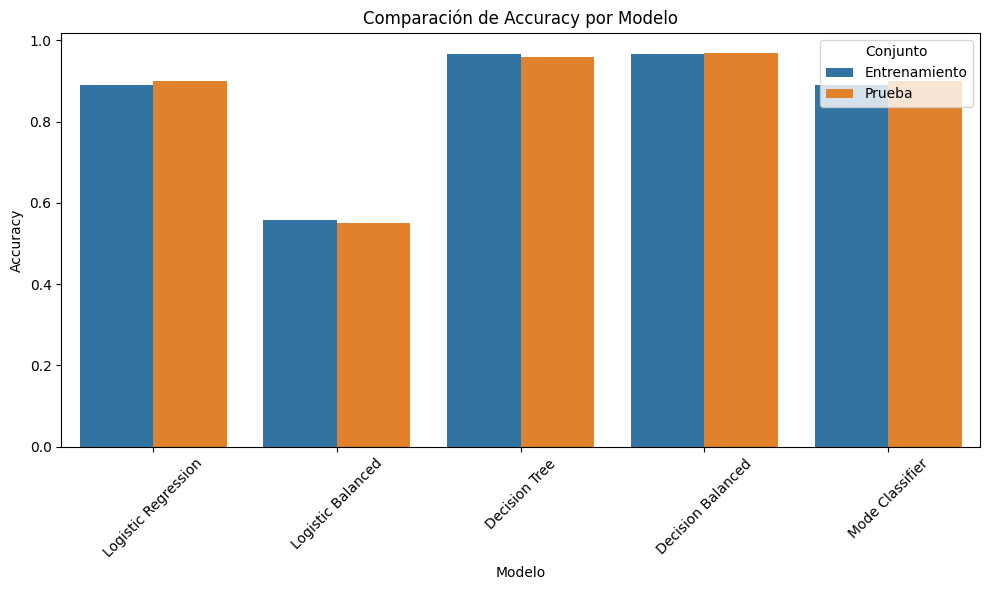

              Metric               Modelo  Entrenamiento    Prueba
0  Balanced Accuracy  Logistic Regression       0.500000  0.500000
1  Balanced Accuracy    Logistic Balanced       0.532303  0.572222
2  Balanced Accuracy        Decision Tree       0.846591  0.800000
3  Balanced Accuracy    Decision Balanced       0.862232  0.850000
4  Balanced Accuracy      Mode Classifier       0.500000  0.500000


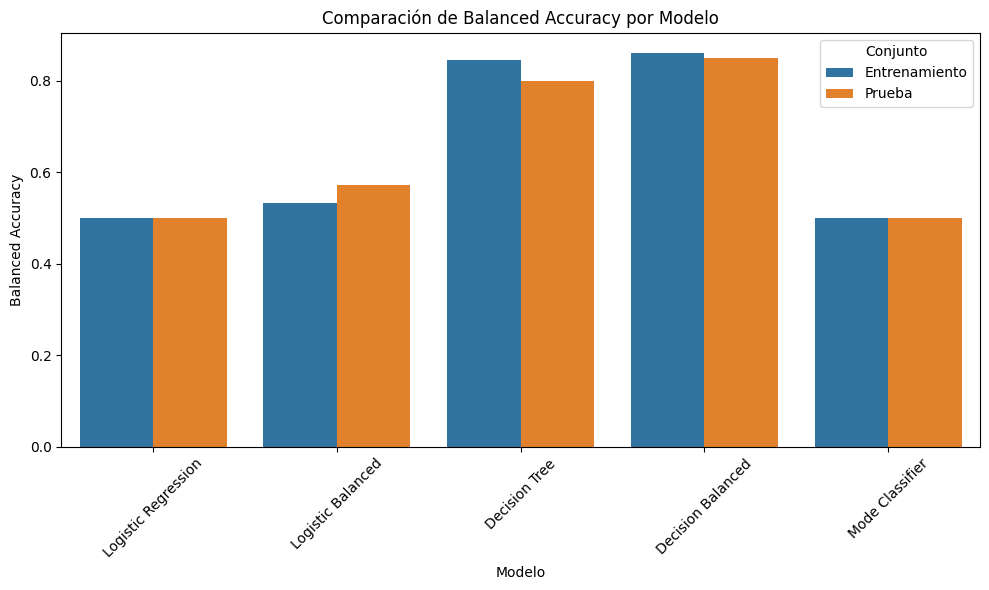

     Metric               Modelo  Entrenamiento    Prueba
0  F1 Score  Logistic Regression       0.000000  0.000000
1  F1 Score    Logistic Balanced       0.199095  0.210526
2  F1 Score        Decision Tree       0.818792  0.750000
3  F1 Score    Decision Balanced       0.831169  0.823529
4  F1 Score      Mode Classifier       0.000000  0.000000


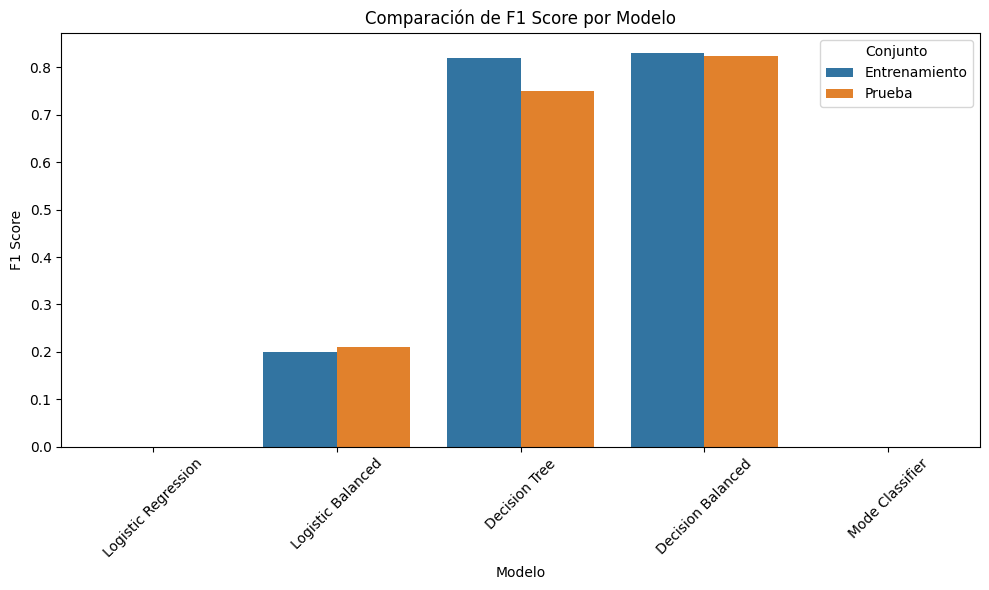

   Metric               Modelo  Entrenamiento  Prueba
0  Recall  Logistic Regression       0.000000     0.0
1  Recall    Logistic Balanced       0.500000     0.6
2  Recall        Decision Tree       0.693182     0.6
3  Recall    Decision Balanced       0.727273     0.7
4  Recall      Mode Classifier       0.000000     0.0


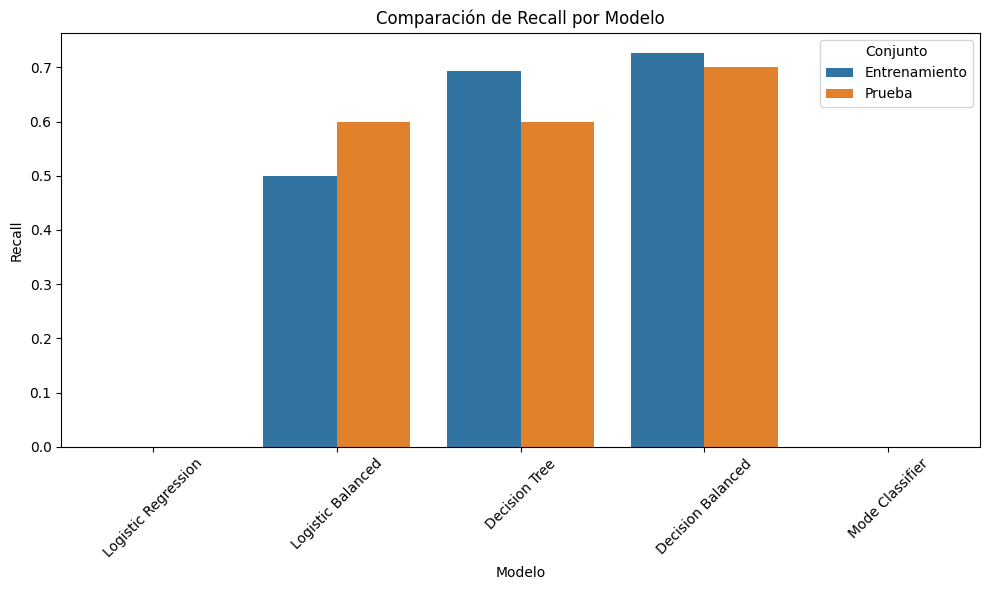

  Metric               Modelo  Entrenamiento    Prueba
0    MCC  Logistic Regression       0.000000  0.000000
1    MCC    Logistic Balanced       0.040700  0.086823
2    MCC        Decision Tree       0.817224  0.757937
3    MCC    Decision Balanced       0.823907  0.823055
4    MCC      Mode Classifier       0.000000  0.000000


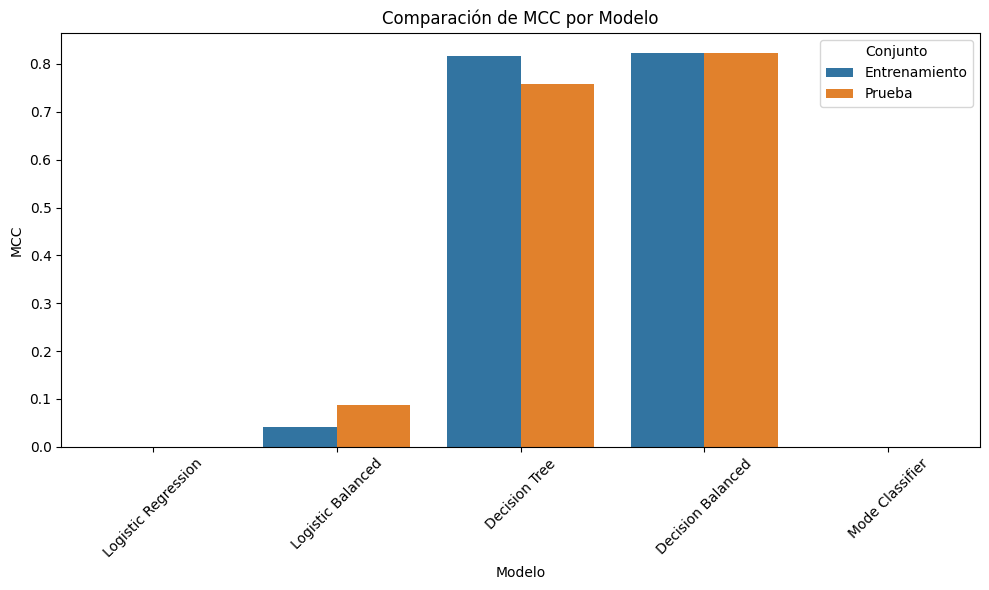

    Metric               Modelo  Entrenamiento    Prueba
0  AUC-ROC  Logistic Regression       0.506879  0.558333
1  AUC-ROC    Logistic Balanced       0.513023  0.544167
2  AUC-ROC        Decision Tree       0.869358  0.867222
3  AUC-ROC    Decision Balanced       0.909634  0.906667


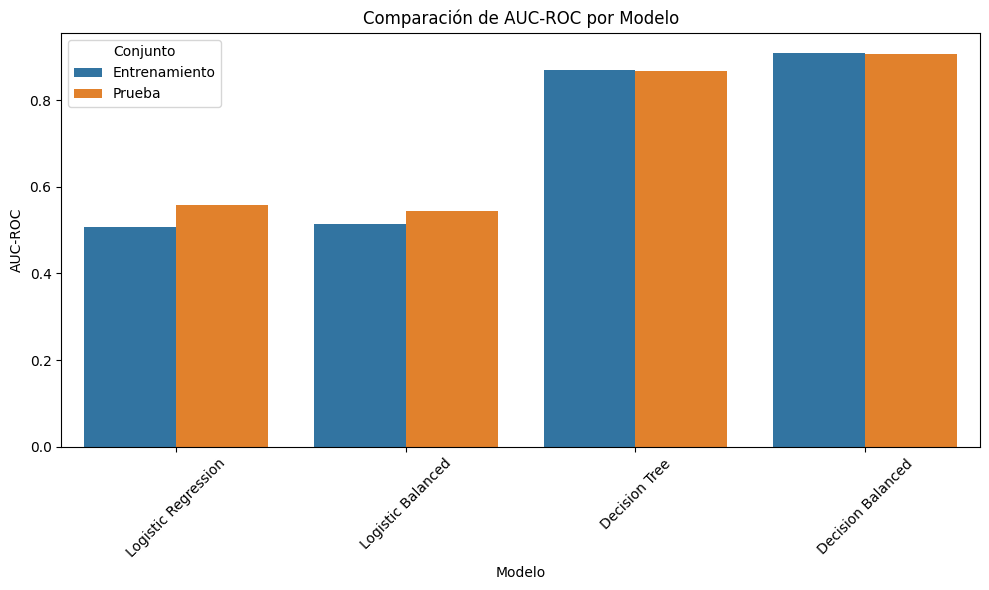

In [123]:
models = {
    'Logistic Regression': lr_model,
    'Logistic Balanced': lr_model_balanced,
    'Decision Tree': dt_model,
    'Decision Balanced': dt_model_balanced,
    'Mode Classifier': mode_model,
}
# Comparar rendimiento en entrenamiento y prueba
compare_performance(models, X_train, y_train, X_test, y_test)


### Class Scores

In [105]:
from sklearn.calibration import calibration_curve

def predict_mode_proba(X, most_common_class):
    # Todos los scores serán 1 para la clase más común y 0 para la otra
    if most_common_class == 0:
        return np.zeros((len(X), 2))
    else:
        return np.ones((len(X), 2))


def compare_class_scores_and_calibration(models, X_test, y_test):
    # Configurar el tamaño del gráfico
    plt.figure(figsize=(10, 14))
    
    # Parte 1: Comparación de Class Scores
    plt.subplot(2, 1, 1)  # 2 filas, 1 columna, primer gráfico
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            scores = model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase 1
            sns.kdeplot(scores, label=name, fill=True, alpha=0.5)
        else:
            # Manejar modelos sin predict_proba
            print(f"{name} no soporta predict_proba, omitiendo...")

    plt.title('Comparación de Class Scores de Modelos')
    plt.xlabel('Class Score')
    plt.ylabel('Densidad')
    plt.legend()

    # Parte 2: Gráficos de Calibración
    plt.subplot(2, 1, 2)  # 2 filas, 1 columna, segundo gráfico
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            prob_true, prob_pred = calibration_curve(y_test, model.predict_proba(X_test)[:, 1], n_bins=20, strategy='uniform')
            plt.plot(prob_pred, prob_true, marker='o', label=name, linestyle='-', linewidth=2)
        else:
            # Manejar modelos sin predict_proba
            continue
    
    # Dibujar línea de calibración perfecta
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibración perfecta', linewidth=2)
    
    plt.title('Curva de Calibración de Modelos')
    plt.xlabel('Probabilidad Predicha')
    plt.ylabel('Frecuencia de Clase Positiva')
    plt.legend()
    plt.tight_layout()
    plt.show()


Mode Classifier no soporta predict_proba, omitiendo...


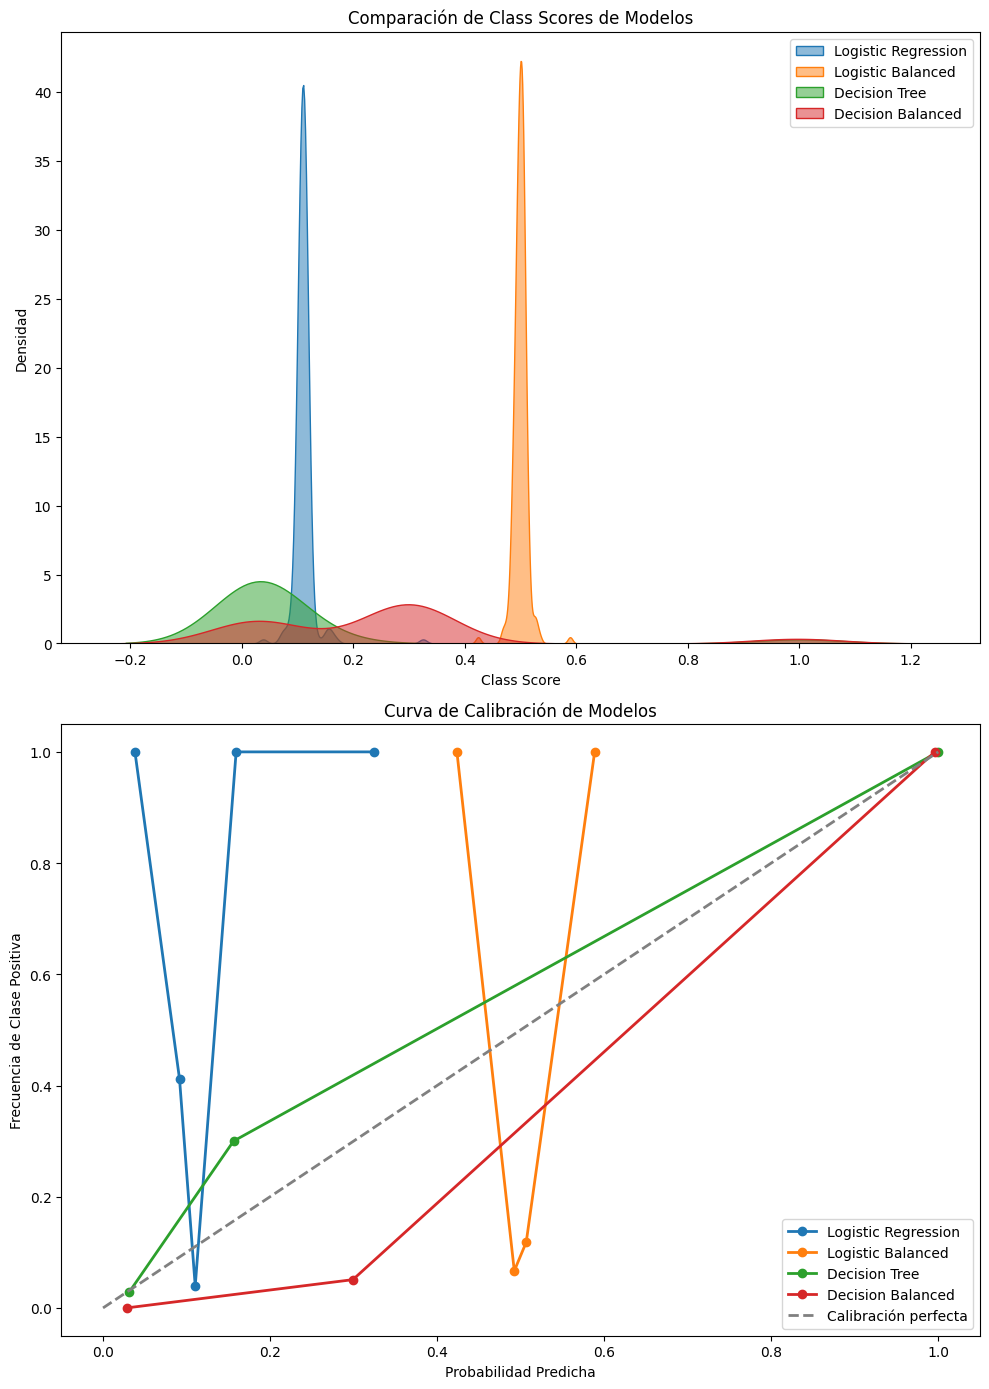

In [125]:
# Definir modelos en un diccionario para facilitar el acceso
models = {
    'Logistic Regression': lr_model,
    'Logistic Balanced': lr_model_balanced,
    'Decision Tree': dt_model,
    'Decision Balanced': dt_model_balanced,
    'Mode Classifier': mode_model,
}
# Comparar "class scores"
compare_class_scores_and_calibration(models, X_test, y_test)


### Preguntas

1. Que esta haciendo `class_weight`='balanced'?
2. Como lo esta balanceando?
3. Como se ve reflejado en el lagrangeano?

# Tarea

Ve los siguientes videos y responde las preguntas de tarea. El valor de la tarea son 30 puntos.

Entregar por discord con nombre: {nombre_notebook}_{clave_unica}_{iniciales}.ipynb para la siguiente clase.

## Videos de Tarea

1. [Decision Trees](https://www.youtube.com/watch?v=_L39rN6gz7Y)
2. [Classification Metrics](https://www.youtube.com/watch?v=qHosBSw_71o)
3. [Multiclass Classification](https://www.youtube.com/watch?v=Jeh531fPhj8)


## Preguntas de Tarea

1. Por que el arbol de decision fue mucho mejor que la regresion logistica?  
   a. Que tiene inherente a si mismo que le da mayor capacidad?   
   b. Para las dos preguntas puedes revisar las graficas del `pairplot` y te dara una pista.   
   c. Tambien puedes ver los class scores abajo para obtener una pista. Ademas, piensa que incluso con el `class_weights` en la `regresion logistica`, sus metricas no son tan buenas como el `decision tree` sin `class_weights` (en este caso particular)  
   [Decision Trees sklearn](https://scikit-learn.org/stable/modules/tree.html)  
     [Decision Trees wiki](https://en.wikipedia.org/wiki/Decision_tree)

Respuesta:

2. Por que la regresion logistica `balanceada` le va tan mal en el `accuracy` pero muy bien en las otras metricas?   
   a. Dirias que es buen o mal modelo? Mejor o peor que la desbalanceada? 

Respuesta:
    

3. Como afectaria una mala calibracion del modelo si tienes que dar una tasa de interes basada en un modelo de prediccion de impago?

Respuesta:
    

### Preguntas rapidas (con explicacion)

Responde las siguientes preguntas de opcion multiple (pueden tener varias respuestas), y da una breve explicacion de tu respuesta.

#### Pregunta 1: Desbalance de Clases
**Escenario:** Estás trabajando en un proyecto de detección de fraudes bancarios. El conjunto de datos está altamente desbalanceado, con solo el 2% de las transacciones etiquetadas como fraudulentas.

**Pregunta:** ¿Qué métrica(s) sería(n) más apropiada(s) para evaluar el rendimiento de tu modelo de clasificación en este escenario y por qué?
- A) Precisión
- B) Recall
- C) Precisión Balanceada
- D) AUC-ROC


Respuesta:
    

#### Pregunta 2: Enfermedad Rara
**Escenario:** Desarrollas un modelo para predecir la presencia de una enfermedad rara en pacientes. Es crucial detectar casi todos los casos positivos, incluso si eso significa aceptar algunos falsos positivos.

**Pregunta:** ¿Qué métrica(s) deberías considerar como prioritaria(s) al evaluar tu modelo?
- A) Precisión
- B) Recall
- C) F1 Score
- D) MCC


Respuesta:
    

#### Pregunta 3: Clasificación Binaria con Costos Desiguales
**Escenario:** Eres responsable de un sistema de alerta temprana para fallas en una planta de producción. El costo de predecir falsamente una falla (falso positivo) es significativamente menor que el costo de no detectar una falla real (falso negativo).

**Pregunta:** ¿Cuál de las siguientes métricas enfatizarías al evaluar tu modelo?
- A) Precisión
- B) Recall
- C) F1 Score
- D) Precisión Balanceada


Respuesta:
    

#### Pregunta 4: Clasificador de Sentimientos
**Escenario:** Estás desarrollando un clasificador de sentimientos para reseñas de productos. Es importante para ti que el clasificador sea igualmente bueno en identificar reseñas positivas y negativas.

**Pregunta:** ¿Qué métrica(s) proporcionaría(n) la mejor visión del rendimiento de tu clasificador en este contexto?
- A) AUC-ROC
- B) Precisión Balanceada
- C) F1 Score
- D) MCC



Respuesta:
    

#### Pregunta 5: Diagnóstico Médico
**Escenario:** Creas un modelo para diagnosticar una enfermedad que tiene una tasa de prevalencia del 50% en el conjunto de datos de prueba. Es importante para ti que el modelo no solo sea preciso, sino que también minimice los errores tanto en la detección de casos positivos como negativos.

**Pregunta:** ¿Cuál(es) de las siguientes métricas te daría(n) una mejor comprensión del rendimiento general de tu modelo?
- A) Precisión
- B) Recall
- C) MCC
- D) AUC-ROC

Respuesta:
    